# Aprendizaje **NO supervisado**

En el aprendizaje no supervisado no tenemos - a priori - información sobre el objetivo (etiqueta, label, columna y, columna a predecir); así que no hay guía (supervisión) sobre lo que debemos obtener. No hay por tanto - a priori - evaluación del modelo a partir de un conjunto de testeo (o validación).

In [42]:
import sys
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Clustering

**Introducción – Clasificación _vs_ Clustering**

In [43]:
from sklearn.datasets import load_iris

In [44]:
#leemos el dataset IRIS
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

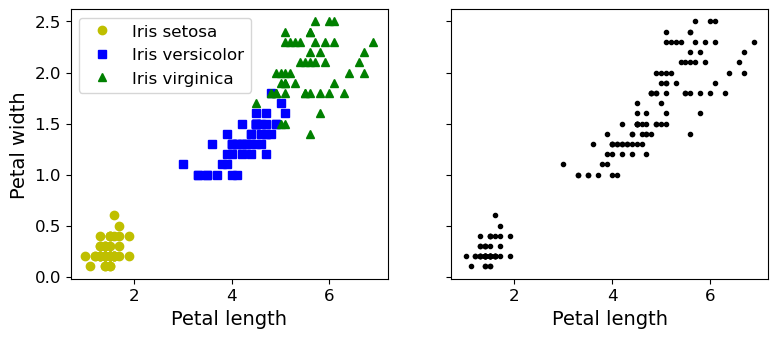

In [45]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121) # == (1,2,1)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122) # == (1,2,2)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

In [46]:
from sklearn.mixture import GaussianMixture

In [47]:
# usamos una mezcla gausiana para predecir las clases
y_pred = GaussianMixture(n_components=3, random_state=42).fit_predict(X)

Asignemos cada cluster a una clase. En lugar de codificar el mapeo, vamos a elegir la clase más común para cada cluster (usando `scipy.stats.mode()`):

In [48]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [49]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

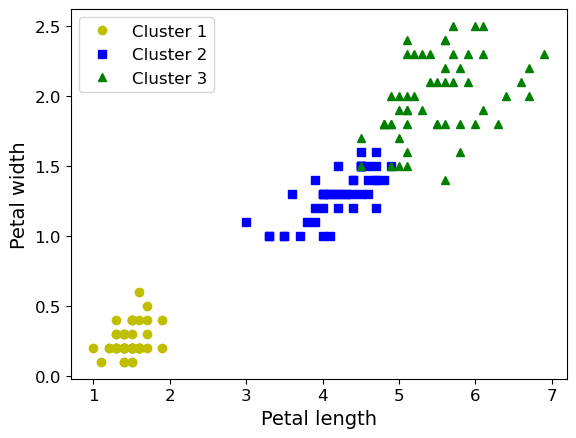

In [50]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [51]:
np.sum(y_pred==y)

145

In [52]:
# En este caso se conoce y , y esto no será así en casos reales

Calculamos la precisión

In [53]:
# calculamos la precisión
np.sum(y_pred==y)/len(y_pred)

0.9666666666666667

## K-Means

Para ver el alorigmo K-MEANS, vamos a generar algunas nubes

In [54]:
from sklearn.datasets import make_blobs

In [55]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [56]:
# creamos las burbujas
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

In [57]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

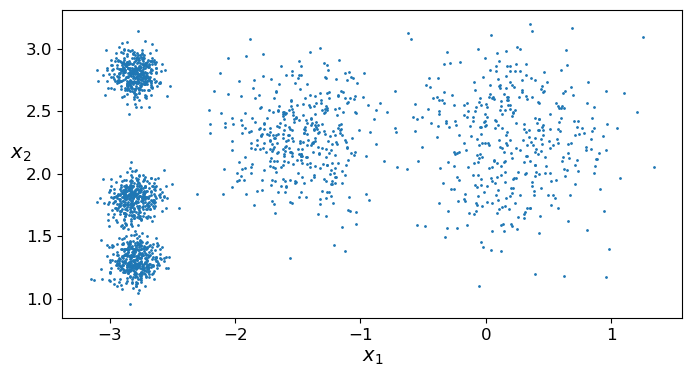

In [58]:
# mostramos las burbujas
plt.figure(figsize=(8,4))
plot_clusters(X)
plt.show()

**Fit y predict**

Vamos a entrenar un K-Means en este conjunto de datos.

Intentará encontrar el centro de cada nube y asignar cada instancia a la nube más cercana:

In [59]:
from sklearn.cluster import KMeans

In [60]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
# entrenamos y predecimos con k means

Cada instancia se asignó a uno de los 5 clusters:

In [61]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

Y ha calculado los siguientres **k** centroides:

In [62]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [63]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**Fronteras (límites) de decisión**

Tracemos los límites de decisión del modelo. Esto nos da un _diagrama de Voronoi_ (https://es.wikipedia.org/wiki/Pol%C3%ADgonos_de_Thiessen):

In [64]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=35, linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

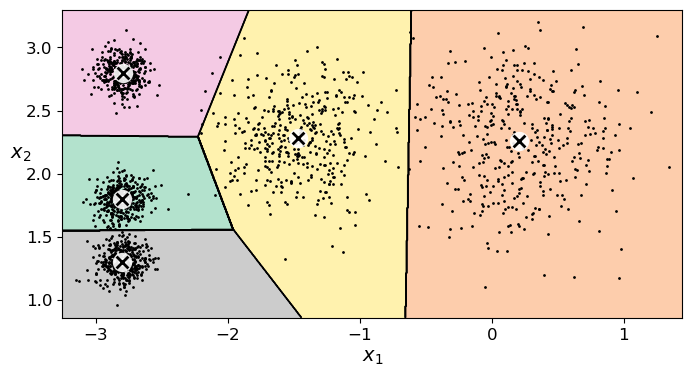

In [65]:
# dibujamos el dataset y los límites de decisión
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.show()

No está mal. 
Algunas de las instancias cercanas a los bordes probablemente se asignaron al clúster equivocado, pero en general se ve bastante bien.

**Hard Clustering _vs_ Soft Clustering**

En lugar de elegir arbitrariamente el cluster más cercano para cada instancia, lo que se llama _hard clustering_, sería mejor medir la distancia de cada instancia a los 5 centroides. Esto es lo que hace el método `transform()`:

In [66]:
kmeans.transform(X_new)


array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### El algoritmo K-Means

El algoritmo K-Means es uno de los algoritmos de clustring más rápidos, y también uno de los más sencillos:
* Primero se inicializan $k$ centroides aleatoriamente: se eligen $k$ instancias distintas aleatoriamente del conjunto de datos y se colocan los centroides en sus ubicaciones.
* Se repite hasta la convergencia (es decir, hasta que los centroides dejan de moverse):
    * Asignar cada instancia al centroide más cercano.
    * Actualizar los centroides para que sean la media de las instancias que se les han asignado.   


La implementación posee varias optimizaciones. Si queremos tener el algoritmo original (tal y como se ha descrito arriba), debemos inicializarlo con el siguiete conjunto de hiperparámetros: `init="random"`, `n_init=1` y `algorithm="full"`.

**Variabilidad K-Means**

En el algoritmo original de K-Means, los centroides se inicializan aleatoriamente y el algoritmo simplemente ejecuta una simple iteración para mejorar gradualmente los centroides, como vimos anteriormente.

Sin embargo, uno de los principales problemas de este enfoque es que si se ejecuta K-Means varias veces (o con diferentes semillas aleatorias), puede converger a soluciones muy diferentes, como se puede ver a continuación:


In [67]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

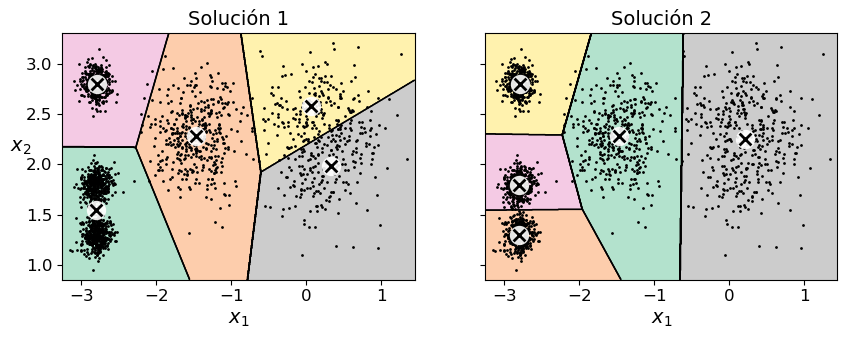

In [68]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X, "Solución 1", "Solución 2")

plt.show()

### Inercia

Para seleccionar el mejor modelo, necesitaremos una forma de evaluar el rendimiento de un K-Mean. Desgraciadamente, el clustering es una tarea no supervisada, por lo que no disponemos de los objetivos. Pero al menos podemos medir la distancia entre cada instancia y su centroide. Esta es la idea detrás de la métrica _inertia_:


In [69]:
kmeans.inertia_


211.5985372581683

La inercia es la suma de las distancias al cuadrado entre cada instancia de entrenamiento y su centroide más cercano.

El método `score()` devuelve la inercia negativa. ¿Por qué negativa? Pues porque el método `score()` de un predictor debe respetar siempre la regla "_mayor es mejor_".

In [70]:
kmeans.score(X)


-211.5985372581683

### Multiple inicializaciones

Por tanto, un método para resolver el problema de la variabilidad consiste simplemente en ejecutar el algoritmo K-Means varias veces con diferentes inicializaciones aleatorias y seleccionar la solución que minimice la inercia. Por ejemplo, aquí están las inercias de los dos modelos "malos" mostrados en la figura anterior:

In [71]:
kmeans_rnd_init1.inertia_

219.43539442771407

In [72]:
kmeans_rnd_init2.inertia_

211.59853725816836

Al establecer el hiperparámetro `n_init`, Scikit-Learn ejecuta el algoritmo original `n_init` veces y selecciona la solución que minimiza la inercia. Por defecto, Scikit-Learn establece `n_init=10`.

In [73]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init='random', n_init=10,algorithm='full', random_state=2)

kmeans_rnd_10_inits.fit(X)



KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

Como se puede ver, terminamos con el modelo inicial, que es sin duda la solución óptima de K-Means (al menos en términos de inercia, y suponiendo $k=5$).

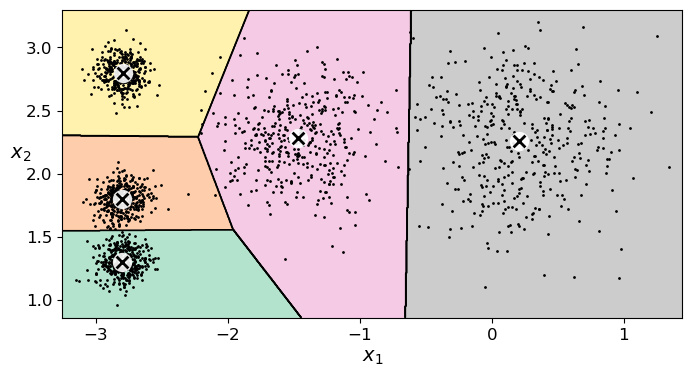

In [74]:
# mostramos los datos y los límites de decisión
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Métodos de inicialización de los centroides


En lugar de inicializar los centroides de forma totalmente aleatoria, es preferible inicializarlos utilizando el siguiente algoritmo, propuesto en un [documento de 2006](https://goo.gl/eNUPw6) por David Arthur y Sergei Vassilvitskii:
* Toma un centroide $c_1$, elegido aleatoriamente.
* Escoge el siguiente centroide de tal manera que se maximize la distancia al centroide anterir (o anteriores).
* Repite el paso previo hasta que todos los centroides $k$ hayan sido escogidos.

El resto del algoritmo K-Means++ es K-Means normal. Con esta inicialización, es mucho menos probable que el algoritmo K-Means converja a una solución subóptima, por lo que es posible reducir `n_init` considerablemente. La mayoría de las veces, esto compensa con creces la complejidad adicional del proceso de inicialización.

Para usar esta inicialización, pon `init="k-means++"` (de hecho se establece por defecto).

### Encontrando el número óptimo de clusters

¿Y si el número de clusters se fija en un valor inferior o superior a 5?

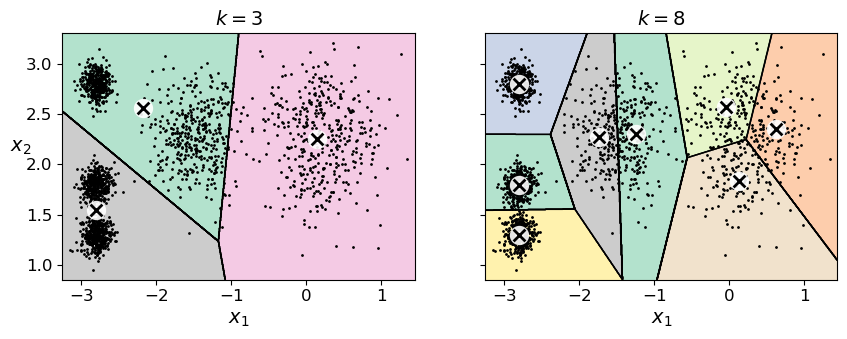

In [75]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, '$k=3$', '$k=8$')

plt.show()




Estos dos modelos no se ven muy bien. ¿Y sus inercias?

In [76]:
kmeans_k3.inertia_

653.2167190021554

In [77]:
kmeans_k8.inertia_

119.11983416102879

No, no podemos simplemente tomar el valor de $k$ que minimiza la inercia, ya que ésta sigue disminuyendo a medida que aumentamos $k$. De hecho, cuantos más clusters haya, más cerca estará cada instancia de su centroide más cercano y, por tanto, menor será la inercia. Sin embargo, podemos representar la inercia en función de $k$ y analizar la curva resultante:

In [78]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1,10)]
inertias     = [model.inertia_ for model in kmeans_per_k]

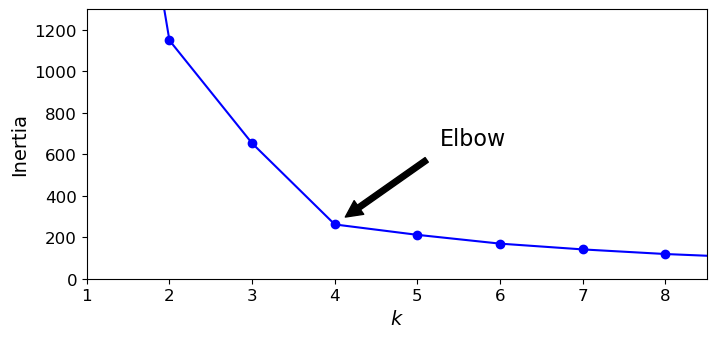

In [79]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Como se puede ver, hay un codo en $k=4$, lo que significa que menos clusters que ésa serían malas, y más clusters no ayudarían mucho y podrían reducir las agrupaciones a la mitad. Así que $k=4$ es una buena elección. Por supuesto, en este ejemplo no es perfecto, ya que significa que las dos manchas de la parte inferior izquierda se considerarán como un solo conglomerado, pero no deja de ser una agrupación bastante buena.

In [80]:
# pues eso, datos y límites de decisión
plt.figure(figsize=(8,4))
kmeans_k4 = KMeans(n_clusters=4, random_state=42)
plot_decision_boundaries(kmeans_k4, X)
plt.show()

NotFittedError: This KMeans instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 800x400 with 0 Axes>

Otro enfoque consiste en observar la _puntuación de silueta_, que es el _coeficiente de silueta_ medio de todas las instancias. El coeficiente de silueta de una instancia es igual a $(b - a)/\max(a, b)$ donde $a$ es la distancia media a las otras instancias del mismo cluster (es la _distancia media intra-cluster_), y $b$ es la _distancia media al cluster más cercano_, es decir, la distancia media a las instancias del siguiente cluster más cercano (definido como el que minimiza $b$, excluyendo el propio cluster de la instancia). El coeficiente de silueta puede variar entre -1 y +1: un coeficiente cercano a +1 significa que la instancia está bien dentro de su propio cluster y lejos de otros clusters, mientras que un coeficiente cercano a 0 significa que está cerca del límite de un cluster, y finalmente un coeficiente cercano a -1 significa que la instancia puede haber sido asignada al cluster equivocado.

In [81]:
from sklearn.metrics import silhouette_score

In [82]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [83]:
silhouette_scores = [silhouette_score(X,model.labels_) for model in kmeans_per_k[1:]]

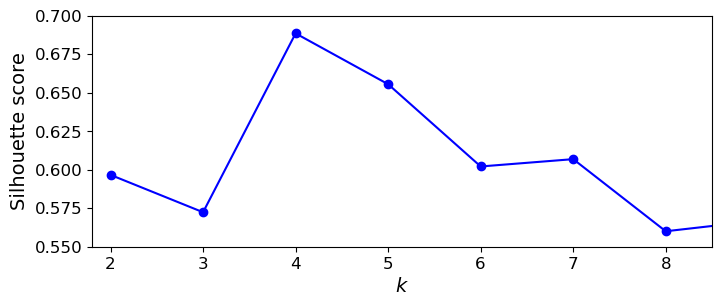

In [84]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Como puede ver, esta visualización es mucho más enriquecedora que la anterior: en particular, aunque confirma que $k=4$ es una muy buena elección, también subraya el hecho de que $k=5$ es bastante buena también.

El coeficiente de silueta de cada instancia, ordenada por el cluster al que está asignada y por el valor del coeficiente, ofrece una visualización aún más informativa. Esto se denomina _diagrama de siluetas_:

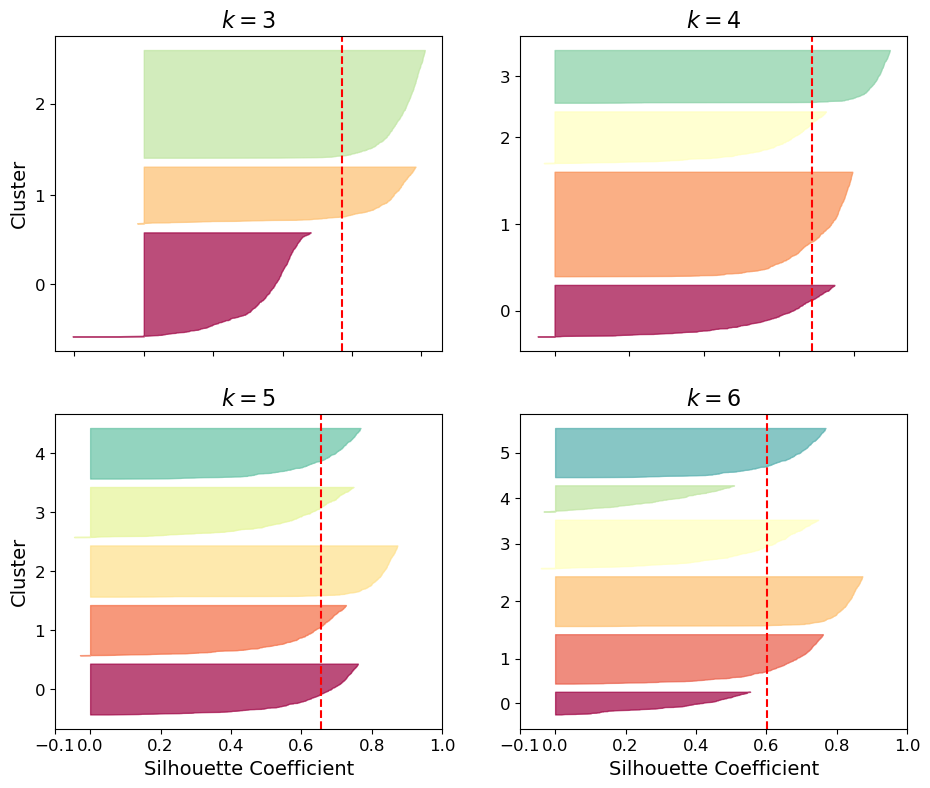

In [85]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Como puede ver, $k=5$ parece la mejor opción, ya que todos los clusters tienen aproximadamente el mismo tamaño, y todos cruzan la línea discontinua, que representa la puntuación media de la silueta.

## Los límites de K-Means

In [86]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [87]:
# mostramos los datos

In [89]:
kmeans_good = KMeans(n_clusters=3, 
                     init=np.array([[-1.5,2.5], [0.5,0],[4,0]]),
                     n_init=1,
                     random_state=42)

kmeans_bad = KMeans(n_clusters=3,
                    random_state=42)

kmeans_good.fit(X)
kmeans_bad.fit(X)


KMeans(n_clusters=3, random_state=42)

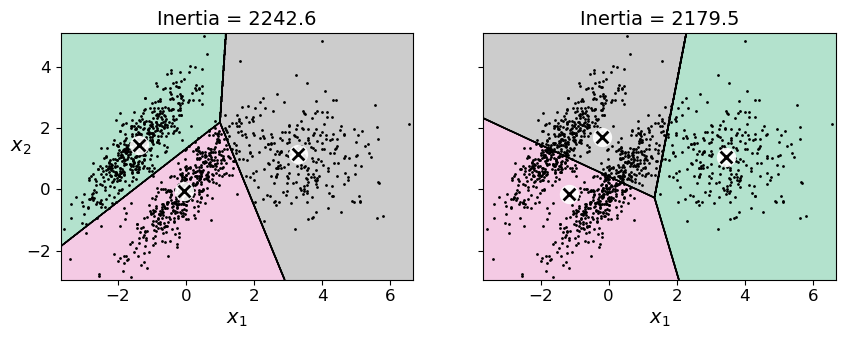

In [90]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

## DBSCAN

DBSCAN se refiere a la agrupación espacial de aplicaciones con ruido basada en la densidad, es el algoritmo de agrupación de datos propuesto a principios de los años 90 por un grupo de comunidad de base de datos y minería de datos.

Ver más: https://es.wikipedia.org/wiki/DBSCAN

In [91]:
from sklearn.datasets import make_moons

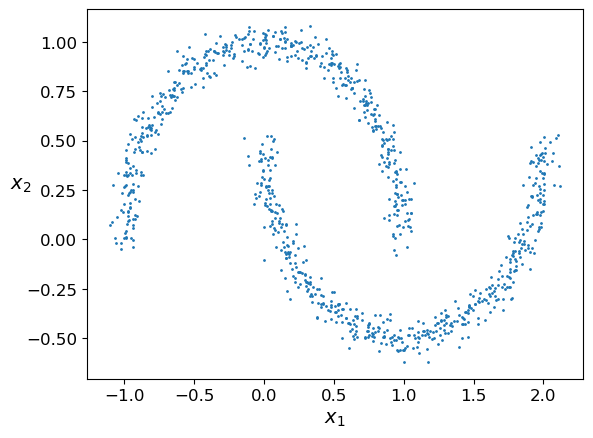

In [92]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
plot_clusters(X)

In [93]:
from sklearn.cluster import DBSCAN

In [95]:
dbscan = DBSCAN(eps=0.05,min_samples=5)
dbscan.fit(X)


DBSCAN(eps=0.05)

In [96]:
# tenemos los agrupamientos en forma de propiedad labels_
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [81]:
# observa los valores negativos
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [97]:
# el índice de las instancias núcleo
len(dbscan.core_sample_indices_)

808

In [98]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [100]:
# el listado de instancias núcleo
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [101]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [102]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

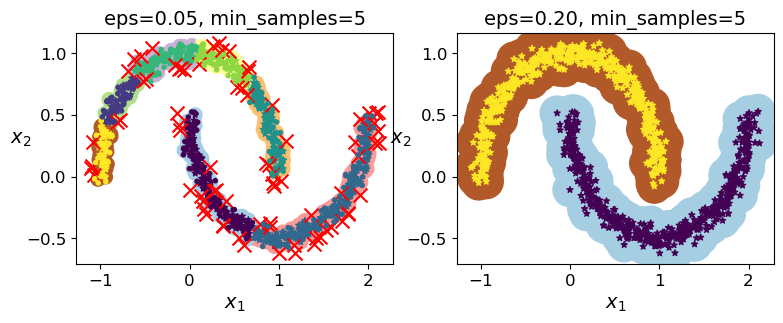

In [108]:
# mostramos los dos resultados
plt.figure(figsize=(9,3))
           
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600)

plt.show()


In [109]:
dbscan = dbscan2
np.unique(dbscan.labels_)
# mostramos las etiquetas (sin duplicados)

array([0, 1])

DBSCAN puede ser usado para clasificar nuevos datos, pero para hacerlo se apoya en un clasificador externo (así podemos elegir cual queremos y no depender de uno concreto; este hecho explica porque DBSAN no tiene el método predict).

Vamos a usar un **KNeighborsClassifier**.
Vamos a entrenar este clasificador con las intancias núcleo, sólo con ellas. Por que son las representativas de las densidades de los datos.

In [110]:
from sklearn.neighbors import KNeighborsClassifier

In [111]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_,
        dbscan.labels_[dbscan.core_sample_indices_])


KNeighborsClassifier(n_neighbors=50)

In [112]:
X_new = np.array([[-0.5,0],[0,0.5],[1,-0.1],[2,1]])
knn.predict(X_new)


array([1, 0, 1, 0])

In [113]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

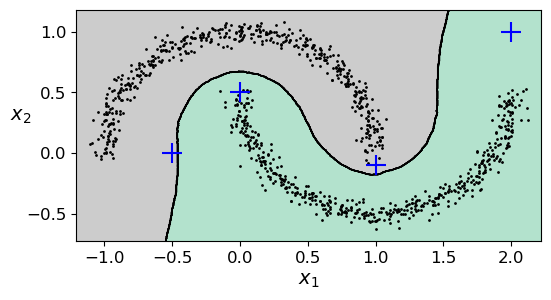

In [114]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

# Mezclas Gaussianas

Ver: Campana de gauss (https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)

In [133]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Entrenemos un modelo de mezcla gaussiana con el conjunto de datos anterior:

In [134]:
from sklearn.mixture import GaussianMixture

In [135]:
gm = GaussianMixture(n_components=3,n_init=10, random_state=42)
gm.fit(X)


GaussianMixture(n_components=3, n_init=10, random_state=42)

Veamos los parámetros estimados por el algoritmo:

In [136]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [137]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [138]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

¿Convergió realmente el algoritmo?

In [139]:
gm.converged_

True

Sí, bien. ¿Cuántas iteraciones tomó?

In [140]:
gm.n_iter_

4

Ahora puedes utilizar el modelo para predecir a qué cluster pertenece cada instancia (**hard clustering**) o las probabilidades de que pertenzca de cada cluster. 

Para ello, utilica el método `predict()` o el método `predict_proba()`:


In [141]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [142]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

Se trata de un modelo generativo, por lo que puedesgenerar nuevas instancias a partir de él (y obtener sus etiquetas):

In [143]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [144]:
y_new

array([0, 0, 1, 2, 2, 2])

Ahora vamos a trazar los límites de decisión resultantes:

In [145]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12), linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r');
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

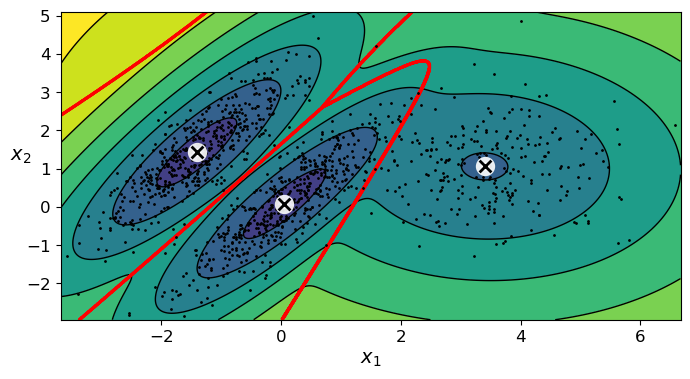

In [146]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

Puede imponer restricciones a las matrices de covarianza que busca el algoritmo estableciendo el hiperparámetro `covariance_type`:
* "**full**" (por defecto): sin restricciones, todos los conglomerados pueden tener forma elipsoidal de cualquier tamaño.
* "**tied**": Todos los conglomerados deben tener la misma forma, que puede ser cualquier elipsoide (es decir, todos comparten la misma matriz de covarianza).
* "**spherical**": todos los conglomerados deben ser esféricos, pero pueden tener diámetros diferentes (es decir, varianzas diferentes).
* "**diag**": los conglomerados pueden tener cualquier forma elipsoidal de cualquier tamaño, pero los ejes del elipsoide deben ser paralelos a los ejes (es decir, las matrices de covarianza deben ser diagonales).


In [147]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [148]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


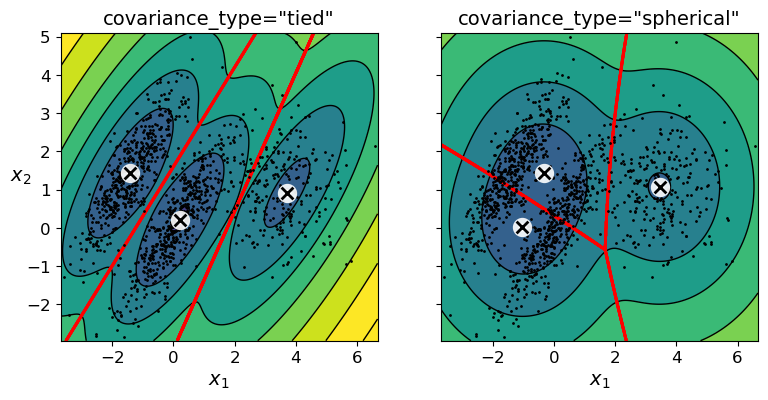

In [149]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)
plt.show()


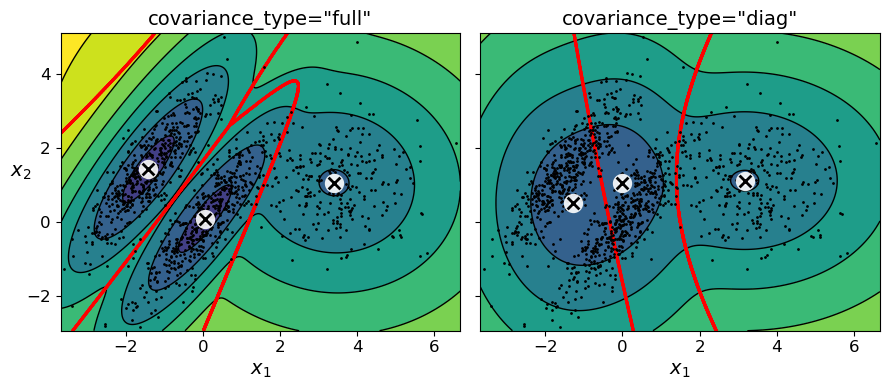

In [151]:
compare_gaussian_mixtures(gm_full, gm_diag,X)
plt.tight_layout()
plt.show()

## Detección de anomalías mediante mezclas gaussianas

Las mezclas gaussianas pueden utilizarse para la _detección de anomalías_: las instancias situadas en regiones de baja densidad pueden considerarse anomalías. Debe definir qué umbral de densidad desea utilizar. Por ejemplo, en una empresa de fabricación que intenta detectar productos defectuosos, la proporción de productos defectuosos suele ser bien conocida. Digamos que es igual a 4%, entonces puede establecer el umbral de densidad para que sea el valor que resulta en tener 4% de las instancias localizadas en áreas por debajo de ese umbral de densidad:

In [152]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

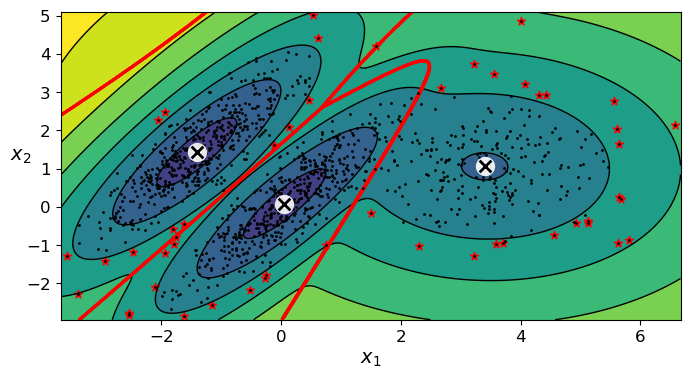

In [153]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

## Selección del número de clusters

No podemos utilizar la **inercia** o la **puntuación de silueta** porque ambas suponen que los clusters son esféricos. En su lugar, podemos intentar encontrar el modelo que minimice un criterio de información teórico como el **Criterio de Información Bayesiano** (**BIC**) o el **Criterio de Información de Akaike** (**AIC**):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ es el número de instancias.
* $p$ es el número de parámetros aprendidos por el modelo.
* $L$ es el valor maximizado de la función de verosimilitud del modelo. Es la probabilidad condicional de los datos observados $\mathbf{X}$, dado el modelo y sus parámetros optimizados.

Tanto el **BIC** como el **AIC** penalizan los modelos que tienen más parámetros que aprender (por ejemplo, más clusters), y recompensan los modelos que se ajustan bien a los datos (es decir, los modelos que dan una alta verosimilitud a los datos observados).

In [155]:
gm.bic(X)

8189.747000497188

In [156]:
gm.aic(X)

8102.52172038215

Vamos a entrenar modelos de mezclas gaussianas con varios valores de $k$ y midamos su BIC:

In [157]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [158]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

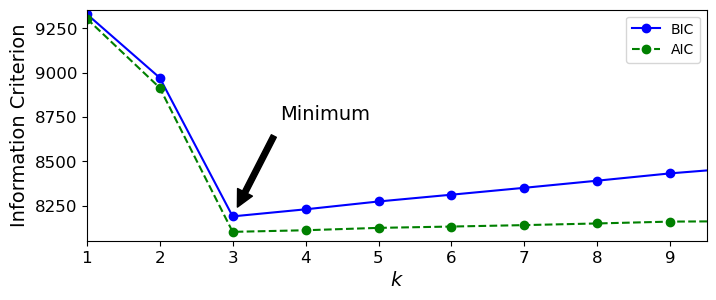

In [159]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Vamos a buscar la mejor combinación de valores tanto para el número de clusters como para el hiperparámetro "covarianze_type":

In [160]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=covariance_type, random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [161]:
best_k

3

In [162]:
best_covariance_type

'full'

## Modelos bayesianos de mezclas gaussianas

En lugar de buscar manualmente el número óptimo de clusters, es posible utilizar en su lugar la clase `BayesianGaussianMixture` que es capaz de dar pesos iguales (o cercanos) a cero a los clusters innecesarios. Basta con establecer el número de componentes en un valor que considere superior al número óptimo de clusters, y el algoritmo eliminará automáticamente aquellos innecesarios.

In [165]:
from sklearn.mixture import BayesianGaussianMixture

In [166]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [167]:
bgm.weights_

array([3.95095317e-01, 2.05162685e-01, 3.99662331e-01, 7.24246329e-05,
       6.58404122e-06, 5.98549202e-07, 5.44135638e-08, 4.94668762e-09,
       4.49698874e-10, 4.08817159e-11])

Si redondeamos con dos dígitos, el algoritmo detectó automáticamente que sólo se necesitan 3 componentes:

In [168]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

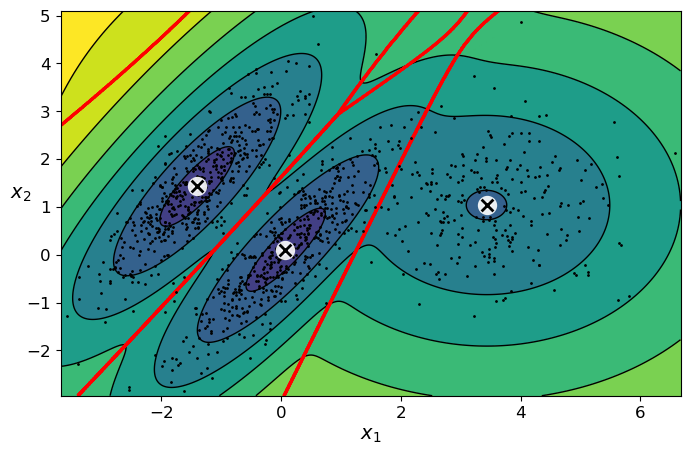

In [169]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

Vamos a aplicar esto a las "medias lunas" del principio.

In [170]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [171]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

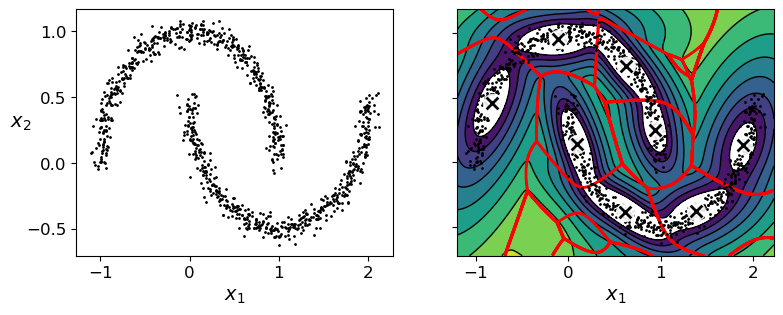

In [172]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)
plt.show()

No muy bien... en lugar de detectar 2 conglomerados con forma de luna, el algoritmo detectó 8 conglomerados elipsoidales. Sin embargo, el gráfico de densidad no tiene tan mal aspecto, 
así que podría servir para detectar anomalías.